_This notebook contains code and comments from Section 3.3 of the book [Ensemble Methods for Machine Learning](https://www.manning.com/books/ensemble-methods-for-machine-learning). Please see the book for additional details on this topic. This notebook and code are released under the [MIT license](https://github.com/gkunapuli/ensemble-methods-notebooks/blob/master/LICENSE)._

---

## 3.3 Combining predictions by meta-learning

In this section, we will look at another approach to constructing heterogeneous ensembles: meta-learning. Instead of carefully designing a combination function to combine predictions, we will learn a combination function over the individual predictions. That is, the predictions of the base estimators are given as inputs to a second-level learning algorithm. Thus, rather than designing one ourselves, we will learn a second-level meta-classification function.

### 3.3.1 Stacking
Stacking is the most common meta-learning method and gets its name because it stacks a second classifier on top of its base estimators. The general stacking procedure has two steps:
1.	level 1: fit base estimators on the training data; this step is the same as before and aims to create a diverse, heterogeneous set of base classifiers.
2.	level 2: construct a new data set from the output of the base classifiers, which become meta-features; meta-features can either be the predictions or the probability of predictions. 

In [1]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

X, y = make_moons(600, noise=0.25, random_state=13)
X, Xval, y, yval = train_test_split(X, y, test_size=0.25)        # Set aside 25% of data for validation
Xtrn, Xtst, ytrn, ytst = train_test_split(X, y, test_size=0.25)  # Set aside a further 25% of data for hold-out test

Simple example: construct a simple heterogeneous ensemble from a 3-nearest neighbor classifier (3nn) and a Gaussian naïve Bayes classifier (gnb) on our 2d synthetic data set. After training the classifiers (3nn and gnb), we can create new features, called meta-features from the **classifier confidences** of these two classifiers.

We can visualize the classifier confidences with the code below. Darker colors indicate greater confidence in classification. 

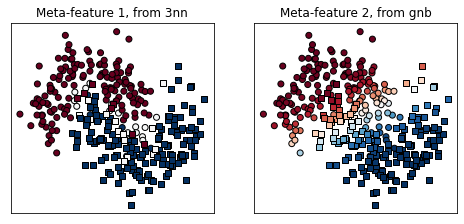

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 3.5))

# Train a KNN classifier and visualize classifier confidences
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(Xtrn, ytrn)
ypred = knn.predict_proba(Xtrn)[:, 1]
ax[0].scatter(Xtrn[ytrn == 0, 0], Xtrn[ytrn == 0, 1], c=ypred[ytrn == 0], cmap=cm.get_cmap('RdBu'), marker='o',
              edgecolors='k')
ax[0].scatter(Xtrn[ytrn == 1, 0], Xtrn[ytrn == 1, 1], c=ypred[ytrn == 1], cmap=cm.get_cmap('RdBu'), marker='s',
              edgecolors='k')
ax[0].set_title('Meta-feature 1, from 3nn')
ax[0].set_xticks([])
ax[0].set_yticks([])

# Train a Gaussian naive Bayes classifier and visualize classifier confidences
gnb = GaussianNB()
gnb.fit(Xtrn, ytrn)
ypred = gnb.predict_proba(Xtrn)[:, 1]
ax[1].scatter(Xtrn[ytrn == 0, 0], Xtrn[ytrn == 0, 1], c=ypred[ytrn == 0], cmap=cm.get_cmap('RdBu'), marker='o',
              edgecolors='k')
ax[1].scatter(Xtrn[ytrn == 1, 0], Xtrn[ytrn == 1, 1], c=ypred[ytrn == 1], cmap=cm.get_cmap('RdBu'), marker='s',
              edgecolors='k')
ax[1].set_title('Meta-feature 2, from gnb')
ax[1].set_xticks([])
ax[1].set_yticks([])

pngFile = '../figures/Chapter03/03-11.png'
plt.savefig('./figures/CH03_F11_Kunapuli.png', dpi=300, bbox_inches='tight');

We have already developed most of the framework we need to quickly implement linear stacking. We can train individual base estimators using fit (Listing 3.1) and obtain meta-features from predict_individual (Listing 3.2). We reproduce these here.

**Listing 3.1**: Fitting different base estimators

In [3]:
# --- Some code to suppress warnings generated due to versioning changes in sklearn and scipy
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")
# --- Can be removed at a future date

from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

estimators = [('dt', DecisionTreeClassifier(max_depth=5)),
              ('svm', SVC(gamma=1.0, C=1.0, probability=True)),
              ('gp', GaussianProcessClassifier(RBF(1.0))),
           	  ('3nn', KNeighborsClassifier(n_neighbors=3)),
              ('rf',RandomForestClassifier(max_depth=3, n_estimators=25)),
              ('gnb', GaussianNB())]

def fit(estimators, X, y):
    for model, estimator in estimators:
        estimator.fit(X, y)
    return estimators

**Listing 3.2**: Individual predictions of base estimators

In [4]:
import numpy as np

def predict_individual(X, estimators, proba=False):
    n_estimators = len(estimators)
    n_samples = X.shape[0] 

    y = np.zeros((n_samples, n_estimators))
    for i, (model, estimator) in enumerate(estimators):
        if proba:
            y[:, i] = estimator.predict_proba(X)[:, 1]  
        else:
            y[:, i] = estimator.predict(X)              
    return y

We can use these functions to train a stacking classifier and make predictions with it.

**Listing 3.8**: Stacking with a second estimator

In [5]:
def fit_stacking(level1_estimators, level2_estimator, X, y, use_probabilities=False):

    fit(level1_estimators, X, y)
    
    X_meta = predict_individual(X, estimators=level1_estimators, proba=use_probabilities)
    
    level2_estimator.fit(X_meta, y)

    final_model = {'level-1': level1_estimators, 
                   'level-2': level2_estimator, 
                   'use-proba': use_probabilities}
    
    return final_model

**Listing 3.9**: Making predictions with a stacked model

In [6]:
def predict_stacking(X, stacked_model):
    level1_estimators = stacked_model['level-1']
    use_probabilities = stacked_model['use-proba']

    X_meta = predict_individual(X, estimators=level1_estimators, proba=use_probabilities)

    level2_estimator = stacked_model['level-2']
    y = level2_estimator.predict(X_meta)
    
    return y

[``LogisticRegression``](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) is often used as the meta-estimator or the second-level estimator. We can train a stacked model with LR using these functions defined above.

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

meta_estimator = LogisticRegression(C=1.0, solver='lbfgs')

stacking_model = fit_stacking(estimators, meta_estimator, Xtrn, ytrn, use_probabilities=True)
ypred = predict_stacking(Xtst, stacking_model)
tst_err = 1 - accuracy_score(ytst, ypred)
tst_err

0.04424778761061943

Visualize the decision boundaries of two stacked models, one where predictions are used as meta-features and the other where prediction probabilities are used as the meta-features.

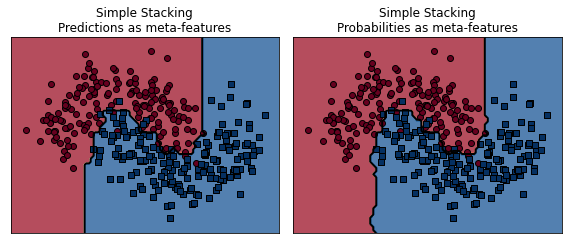

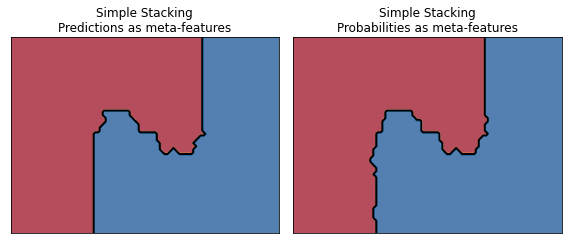

In [14]:
%matplotlib inline

from visualization import get_colors
cm = get_colors(colormap='RdBu')

feature_type = ['Predictions as meta-features', 'Probabilities as meta-features']
figure_numbers = [13, 14]

xMin, xMax = Xtrn[:, 0].min() - 0.25, Xtrn[:, 0].max() + 0.25
yMin, yMax = Xtrn[:, 1].min() - 0.25, Xtrn[:, 1].max() + 0.25
xMesh, yMesh = np.meshgrid(np.arange(xMin, xMax, 0.05),
                           np.arange(yMin, yMax, 0.05))

for f, scatter in enumerate([True, False]):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 3.5))
    for i, p in enumerate([False, True]):
        model = fit_stacking(estimators, meta_estimator, Xtrn, ytrn, use_probabilities=p)
        zMesh = predict_stacking(np.c_[xMesh.ravel(), yMesh.ravel()], model)
        zMesh = zMesh.reshape(xMesh.shape)

        # Compute the test error
        # ypred = predict_stacking(Xtst, model)
        # tst_err = 1 - accuracy_score(ytst, ypred)

        ax[i].contourf(xMesh, yMesh, zMesh, cmap='RdBu', alpha=0.75)
        if scatter:
            ax[i].contour(xMesh, yMesh, zMesh, [0.5], colors='k', linewidths=2)
            ax[i].scatter(Xtrn[ytrn == 0, 0], Xtrn[ytrn == 0, 1], marker='o', c=cm[0], edgecolors='k')
            ax[i].scatter(Xtrn[ytrn == 1, 0], Xtrn[ytrn == 1, 1], marker='s', c=cm[1], edgecolors='k')
        else:
            ax[i].contour(xMesh, yMesh, zMesh, [0.5], colors='k', linewidths=2)

        # ax[i].text((xMax + xMin)/2-2, yMax-0.25, 'test err = {0:4.2f}%'.format(tst_err*100))
        ax[i].set_title('{0}\n{1}'.format('Simple Stacking', feature_type[i]))
        ax[i].set_xticks([])
        ax[i].set_yticks([])
        
    fig.tight_layout()
    pngFile = './figures/CH03_F{0:02d}_Kunapuli.png'.format(figure_numbers[f])
    plt.savefig(pngFile, dpi=300, bbox_inches='tight');

---
### 3.3.2	Stacking with cross validation

Cross validation is a model validation and evaluation procedure that is commonly employed to simulate out-of-sample testing, tune model hyper-parameters and test the effectiveness of machine learning models. 

The prefix “k-fold” is used to describe the number of subsets we will be partitioning our data set into. For example, in 5-fold cross validation, data is (often randomly) partitioned into 5 non-overlapping subsets. This gives rise to 5 folds, or combinations of these subsets for training and validation.

A key part of stacking with cross validation is to split the data set into training and validation sets for each fold. ``scikit-learn`` contains many utilities to perform precisely this, and the one we will use is called [``model_selection.StratifiedKFold``](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html?highlight=stratified%20k%20fold#sklearn.model_selection.StratifiedKFold), which returns stratified folds (this means that the folds preserve class distributions in the data set when generating folds). 

The listing below demonstrates how to perform stacking with cross-validation.

**Listing 3.10**: Stacking with cross validation

In [15]:
from sklearn.model_selection import StratifiedKFold

def fit_stacking_with_CV(level1_estimators, level2_estimator, X, y, n_folds=5, use_probabilities=False):
    n_samples = X.shape[0]
    n_estimators = len(level1_estimators)
    X_meta = np.zeros((n_samples, n_estimators))

    splitter = StratifiedKFold(n_splits=n_folds, shuffle=True)
    for trn, val in splitter.split(X, y):
        level1_estimators = fit(level1_estimators, X[trn, :], y[trn])
        X_meta[val, :] = predict_individual(X[val, :],
                                           estimators=level1_estimators,  
                                           proba=use_probabilities)

    level2_estimator.fit(X_meta, y) 

    level1_estimators = fit(level1_estimators, X, y)

    final_model = {'level-1': level1_estimators, 
                   'level-2': level2_estimator, 
                   'use-proba': use_probabilities}

    return final_model

As before, ``LogisticRegression`` is used as the (level 2) meta-estimator. 

In [17]:
stacking_model = fit_stacking_with_CV(estimators, meta_estimator,  Xtrn, ytrn, 
                                      n_folds=5, use_probabilities=True)
ypred = predict_stacking(Xtst, stacking_model)
tst_err = 1 - accuracy_score(ytst, ypred)
tst_err = 1 - accuracy_score(ytst, ypred)
tst_err

0.03539823008849563

Again, as be fore, we visualize the decision boundaries of two stacked models, one where predictions are used as meta-features and the other where prediction probabilities are used as the meta-features.

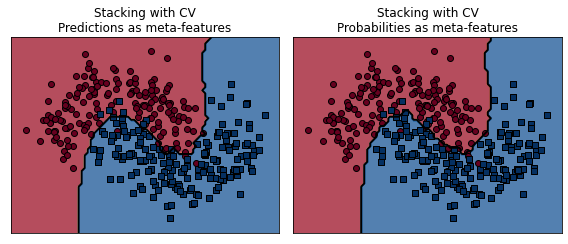

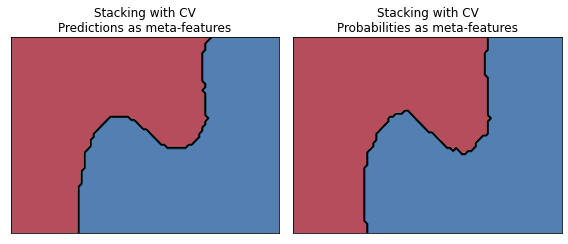

In [19]:
%matplotlib inline

from visualization import get_colors
cm = get_colors(colormap='RdBu')

feature_type = ['Predictions as meta-features', 'Probabilities as meta-features']
figure_numbers = [17, 99]

xMin, xMax = Xtrn[:, 0].min() - 0.25, Xtrn[:, 0].max() + 0.25
yMin, yMax = Xtrn[:, 1].min() - 0.25, Xtrn[:, 1].max() + 0.25
xMesh, yMesh = np.meshgrid(np.arange(xMin, xMax, 0.05),
                           np.arange(yMin, yMax, 0.05))

for f, scatter in enumerate([True, False]):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 3.5))
    for i, p in enumerate([False, True]):
        model = fit_stacking_with_CV(estimators, meta_estimator, Xtrn, ytrn, use_probabilities=p)
        zMesh = predict_stacking(np.c_[xMesh.ravel(), yMesh.ravel()], model)
        zMesh = zMesh.reshape(xMesh.shape)

        # Compute the test error
        # ypred = predict_stacking(Xtst, model)
        # tst_err = 1 - accuracy_score(ytst, ypred)

        ax[i].contourf(xMesh, yMesh, zMesh, cmap='RdBu', alpha=0.75)
        if scatter:
            ax[i].contour(xMesh, yMesh, zMesh, [0.5], colors='k', linewidths=2)
            ax[i].scatter(Xtrn[ytrn == 0, 0], Xtrn[ytrn == 0, 1], marker='o', c=cm[0], edgecolors='k')
            ax[i].scatter(Xtrn[ytrn == 1, 0], Xtrn[ytrn == 1, 1], marker='s', c=cm[1], edgecolors='k')
        else:
            ax[i].contour(xMesh, yMesh, zMesh, [0.5], colors='k', linewidths=2)

        # ax[i].text((xMax + xMin)/2-2, yMax-0.25, 'test err = {0:4.2f}%'.format(tst_err*100))
        ax[i].set_title('{0}\n{1}'.format('Stacking with CV', feature_type[i]))
        ax[i].set_xticks([])
        ax[i].set_yticks([])
        
    fig.tight_layout()
    pngFile = './figures/CH03_F{0:02d}_Kunapuli.png'.format(figure_numbers[f])
    plt.savefig(pngFile, dpi=300, bbox_inches='tight');